# Bored Ape Yacht Club Value Estimation

The motivation for this work is to develop a reasonable model that can estimate the value of BAYC NFT. 

There are two goals:

1. Through the process of feature selection we can better understand what properties of the NFTS are predictive with respect to value.
2. Create a criterion for labeling 'undervalued' NFTs when new sales in the OpenSea market arrive.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# display formatting for floats
pd.options.display.float_format = '{:,.6f}'.format

In [3]:
df = pd.read_csv('bored_apes.csv', parse_dates=['SaleDate']).rename(columns={'index': 'TokenId'})
# Bored Ape #225 has a sale of 0 USD (transfer to same owner with address labelled Vault)
# not sure why transfer style activity sometimes gets labelled as a sale
df = df.loc[df['USDPrice'] != 0]
df = df.sort_values(['SaleDate'])  # sort by sale date and time

We want to determine value of an NFT, which changes over time of course. A possible target can be the extension from a robust moving average (since there are a lot of outliers in the data).

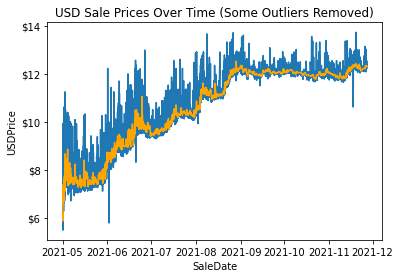

In [4]:
ts = df.groupby('SaleDate').agg({'USDPrice': 'mean'})
ts_outrm = ts.loc[ts['USDPrice'] < 10e5]
# Rolling median for outlier robustness
log_price = np.log(ts_outrm['USDPrice'])
rolling_median = log_price.rolling(window=14).median()

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter('${x:,.0f}')
sns.lineplot(x='SaleDate', y=log_price, data=ts_outrm)
sns.lineplot(x=ts_outrm.index, y=rolling_median, color='orange') \
    .set_title('USD Sale Prices Over Time (Some Outliers Removed)')
plt.show()

The rolling mean is not as robust to influence from outliers as other methods. Below I'll try to create another rolling estimator of a 'base' price. It will remove outliers as defined through rolling mean and standard deviation. Then I'll fill those outliers with the previous values (**just to create the rolling baseline**)

Rolling Median with window 7
EWM span 7

In [5]:
# rolling_median = df['USDPrice'].rolling(window=3, min_periods=1).median()
# ewm = df['USDPrice'].ewm(span=3).mean()
# df['USDPriceEWM'] = (rolling_median + ewm) / 2

In [6]:
# df.loc[df['TokenId']==8029, ['USDPrice', 'USDPriceEWM', 'SaleDate']]

In [7]:
df['LogUSDPrice'] = np.log(df['USDPrice'])

In [8]:
mean = df['LogUSDPrice'].ewm(span=14).mean()  # exponentially weighted moving average with 14 point window
std = df['LogUSDPrice'].ewm(span=14).std()

mean_plus_std = mean + 1.7*std
# mean_minus_std = mean - 2*std


# is_outlier = (df['LogUSDPrice'] > mean_plus_std) | (df['LogUSDPrice'] < mean_minus_std)
is_outlier = df['LogUSDPrice'] > mean_plus_std

dfo, dfi = df.loc[is_outlier, :], df.loc[~is_outlier, :]
for data in [dfo, dfi]:
    rolling_median = data['LogUSDPrice'].rolling(window=7, min_periods=1).median()
    ewm = data['LogUSDPrice'].ewm(span=14).mean()
    data['LogUSDPriceEWM'] = (rolling_median + ewm) / 2

<ipython-input-8-9828587d4e00>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['LogUSDPriceEWM'] = (rolling_median + ewm) / 2


**Results** (over the origin dataset)

<AxesSubplot:xlabel='SaleDate', ylabel='LogUSDPrice'>

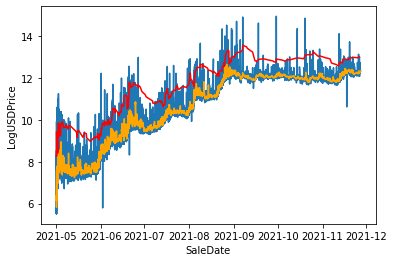

In [9]:
sns.lineplot(x='SaleDate', y='LogUSDPrice', data=df)
sns.lineplot(x='SaleDate', y='LogUSDPriceEWM', color='orange', data=dfi)
sns.lineplot(x='SaleDate', y='LogUSDPriceEWM', color='red', data=dfo)

## Handling Missing Data

In [10]:
df.isna().any()

TokenId             False
LastSalePrice       False
Background          False
BackgroundRarity    False
Earring              True
EarringRarity        True
Fur                 False
FurRarity           False
Eyes                False
EyesRarity          False
Mouth               False
MouthRarity         False
Clothes              True
ClothesRarity        True
Hat                  True
HatRarity            True
LastSaleToken       False
NumberOfSales       False
SaleDate            False
USDPrice            False
LogUSDPrice         False
dtype: bool

In [11]:
df = dfi

To handle the NaNs contained in the traits columns, we can simply **calculate their rarity using the non-missing data**.

In [12]:
rarity_cols = [c for c in df.columns if 'Rarity' in c]  # get all numeric rarity related cols
# clean up na's in rarity cols
def fill_trait_na(col) -> float:
    """Calculate the missing data in trait rarity columns"""
    fill_value = 1 - col.dropna().unique().sum()
    return fill_value

df[rarity_cols] = df[rarity_cols].apply(lambda x: x.fillna(fill_trait_na(x)))

Change NaNs to None. This way it represents an actual category (not having a hat for example).

In [13]:
traits = ['Background', 'Earring', 'Fur', 'Eyes', 'Mouth', 'Clothes', 'Hat']
df[traits] = df[traits].fillna('None')

## Engineering a couple new features

In [14]:
# Percentage Extension from the Exponential Weighted Moving Average
df['PctExtensionEWM'] = df.apply(lambda x: (x['LogUSDPrice'] - x['LogUSDPriceEWM']) / x['LogUSDPriceEWM'], axis=1)

It could be valuable for the ape to have **matching** properties. We will create a column for the greatest number of matching properties:

In [15]:
trait_cols = [
    'Background',
    'Earring',
    'Mouth',
    'Clothes',
    'Hat',
    'Fur',
    'Eyes',
]
from collections import Counter
def find_matches(row, categories):
    traits = row[categories].values
    keywords = []
    for trait in traits:
        split = trait.split(' ')
        for word in split:
            keywords.append(word)
    if 'None' in keywords:
        keywords.remove('None')
    counts = Counter(keywords)
    most_common = counts.most_common(1)
    matches = most_common[0][1] - 1
    if matches:
        return 1
    return 0
df['HasMatches'] = df.apply(lambda x: find_matches(x, trait_cols), axis=1)

Save our progress so far as CSV:

In [16]:
df.to_csv('feature_engineered.csv', index=False)

## Data Preprocessing

In [17]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

To prepare the data for the model we will need to do some scaling and normalizing of the target variable and create numerical features for the training data through encoding.

### Scaling and Normalizing Target

In [18]:
# df['PctExtensionEWMScaled'] = np.log(df['PctExtensionEWM']+2) # shifted and then log scaled to normalize

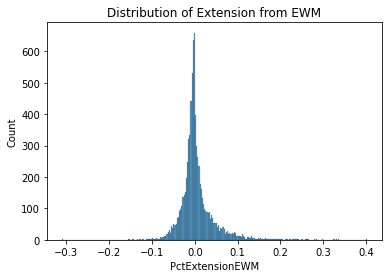

In [19]:
fig, ax = plt.subplots()
sns.histplot(df['PctExtensionEWM']).set_title('Distribution of Extension from EWM')
plt.show()

### Encoding Categorical Features

In [20]:
categorical_feature_cols = [
    'Background',
    'Earring',
    'Mouth',
    'Clothes',
    'Hat',
    'Fur',
    'Eyes',
]
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[categorical_feature_cols]).toarray())
enc_df.columns = enc.get_feature_names_out()
dfp = pd.concat([df, enc_df], axis=1, join="inner") # concatente encoded df
df = dfp.drop(columns=categorical_feature_cols)
df.to_csv('processed.csv', index=False)

In [21]:
exclude_features = [
    'TokenId', 'LastSalePrice', 'LastSaleToken',
    'SaleDate', 'USDPrice', 'USDPriceEWM', 'PctExtensionEWM'
]
# remove the rarity features since they are completely correlated with the categoricals
exclude_features.extend([feature for feature in df.columns if 'Rarity' in feature])
features = [feature for feature in df.columns if feature not in exclude_features]

## Modeling

In [22]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor

In [23]:
X = df.loc[:, features]
y = df['PctExtensionEWM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Model Selection

In [24]:
from typing import List
def model_selection(models: List[dict], scores: List[str], X_train, y_train) -> dict:
    """Find the best model"""
    results = {}
    for candidate in models:
        model = GridSearchCV(
            candidate['constructor'], param_grid=candidate['param_grid'], scoring=scores
        )
        model.fit(X_train, y_train)
        mean_test_score = model.cv_results_['mean_test_score'].mean()
        results[candidate['name']] = mean_test_score
    print("The winner is: {}".format(
        max(results, key=results.get)
    ))
    return results

In [25]:
models = [
    {
        'name': 'LinearRegression',
        'constructor': LinearRegression(),
        'param_grid': {}
    },
    {
        'name': 'RandomForest',
        'constructor': RandomForestRegressor(random_state=0),
        'param_grid': {}
    },
    {
        'name': 'Huber',
        'constructor': HuberRegressor(),
        'param_grid': {'epsilon': [10], 'max_iter': [1000]}
    }
]
model_selection(models, 'neg_root_mean_squared_error', X_train, y_train)

The winner is: Huber


{'LinearRegression': -0.006226974814358436,
 'RandomForest': -0.007128902566529945,
 'Huber': -0.006226952353824544}

## Stacking

In [26]:
from sklearn.ensemble import VotingRegressor

In [27]:
estimators = [('randomforest', RandomForestRegressor(random_state=42)),
              ('linear', LinearRegression()),
              ('huber', HuberRegressor(epsilon=10, max_iter=800))]

In [28]:
ereg = VotingRegressor(estimators)

In [29]:
cross_validate(ereg, X_train, y_train, cv=3,
               scoring=('neg_mean_squared_error'),
               return_train_score=True)

{'fit_time': array([5.4600327 , 6.01118684, 4.76999187]),
 'score_time': array([0.06993079, 0.07079196, 0.07304287]),
 'test_score': array([-2.33571089e-05, -3.53743990e-05, -2.58581156e-05]),
 'train_score': array([-1.73717712e-05, -1.74384582e-05, -1.70735859e-05])}

In [30]:
ereg.fit(X_train, y_train)
y_actual, y_pred = y_test, ereg.predict(X_test)
predict_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
from sklearn import metrics
-metrics.mean_squared_error(y_test, y_pred)

-2.296247244231736e-05

In [31]:
predicted_merged = df.merge(predict_df, how='left', left_index=True, right_index=True)
predicted_merged = predicted_merged.loc[~predicted_merged['Predicted'].isna()]

cols = predicted_merged.columns[0:]
pm = predicted_merged.loc[:, ['TokenId', 'SaleDate', 'LogUSDPriceEWM', 'Actual', 'Predicted', 'USDPrice', 'PctExtensionEWM']]

pm['PredictedUSDPrice'] = np.exp(pm['LogUSDPriceEWM'] * (1 + pm['Predicted']))

pm.sample(10)

,TokenId,SaleDate,LogUSDPriceEWM,Actual,Predicted,USDPrice,PctExtensionEWM,PredictedUSDPrice
4728,5662,2021-06-20 15:12:02.665861,10.042150,0.040716,0.044918,"34,579.776000",0.040716,"36,070.400928"
3188,3926,2021-08-16 06:42:07.451449,11.202909,0.004705,0.005127,"77,312.656000",0.004705,"77,679.731085"
4039,4867,2021-10-04 02:56:51.818299,12.134187,0.008293,0.009801,"205,831.176672",0.008293,"209,632.389280"
6901,8286,2021-07-09 10:35:48.626860,9.639105,0.030202,0.033180,"20,542.033600",0.030202,"21,140.222022"
1963,2531,2021-07-11 20:24:03.953543,9.900968,0.002604,0.002022,"20,470.655050",0.002604,"20,353.100752"
5323,6343,2021-05-03 03:43:49.216514,8.112223,-0.071113,-0.067557,"1,873.071200",-0.071113,"1,927.898533"
5399,6428,2021-05-01 19:07:32.381343,6.865834,0.026798,0.023151,"1,152.659200",0.026798,"1,124.153148"
3103,3836,2021-07-19 07:32:26.511108,10.253620,-0.009630,-0.012442,"25,716.286000",-0.009630,"24,985.331013"
3635,4418,2021-05-15 20:42:03.266022,8.228589,0.179279,0.172396,"16,379.800000",0.179279,"15,477.842010"
3327,4072,2021-09-30 04:02:29.450316,12.170149,0.001440,0.001146,"196,352.852500",0.001440,"195,653.872534"


In [32]:
# Create a measure of accuracy
pm['Accuracy'] = 1 - abs(pm['PredictedUSDPrice'] - pm['USDPrice']) / ((pm['PredictedUSDPrice'] + pm['USDPrice']) / 2)

In [33]:
pm.sort_values('Accuracy', ascending=False).tail(10)

,TokenId,SaleDate,LogUSDPriceEWM,Actual,Predicted,USDPrice,PctExtensionEWM,PredictedUSDPrice,Accuracy
4524,5419,2021-05-01 23:37:45.735068,7.268305,0.200866,0.175502,"6,174.960000",0.200866,"5,135.367969",0.816169
4144,4985,2021-05-01 22:18:36.573953,7.155880,0.160247,0.133580,"4,034.307200",0.160247,"3,333.442868",0.809748
6431,7658,2021-08-05 20:53:32.057031,11.743561,0.079698,0.096180,"321,097.920000",0.079698,"389,670.576045",0.807046
4849,5798,2021-05-02 06:55:33.486661,7.252591,0.172700,0.144956,"4,939.968000",0.172700,"4,039.595824",0.799462
2521,3199,2021-05-01 09:57:24.987936,7.496242,-0.126822,-0.099536,696.141500,-0.126822,854.142962,0.796165
7203,8627,2021-08-25 16:53:33.497150,12.160468,0.095222,0.114569,"608,296.280000",0.095222,"769,637.631782",0.765821
6232,7398,2021-05-02 10:54:29.498962,7.588034,0.335139,0.293336,"25,111.504000",0.335139,"18,285.760976",0.685430
4409,5302,2021-05-01 10:06:50.346742,6.700556,0.242105,0.188211,"4,116.640000",0.242105,"2,868.870557",0.642755
6945,8350,2021-05-01 09:17:57.379578,6.600820,0.259350,0.191963,"4,075.473600",0.259350,"2,612.159303",0.562382
1431,1913,2021-05-02 13:52:27.748670,7.579748,0.401114,0.331442,"40,949.500000",0.401114,"24,148.941985",0.483841


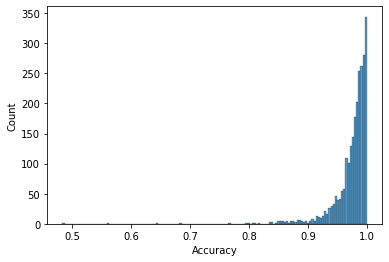

In [34]:
fig, ax = plt.subplots()
ax = sns.histplot(pm['Accuracy'])
plt.show()

In [35]:
def valuate(token_id, df, features, current_price_ewa):
    token_data = df.loc[df['TokenId']==token_id, features]
    y_pred = ereg.predict(token_data)
    return float(current_price_ewa * (1 + y_pred))

In [36]:
valuate(9361, df, features, df.sort_values('SaleDate', ascending=False)['USDPriceEWM'].iloc[0])

KeyError: 'USDPriceEWM'